In [1]:
import sys
sys.path.append('../../src')

import pickle
from tuneable_counterfactuals_explainer.explainer import Explainer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
model = pickle.load(open('model/model.pkl', 'rb'))
training_data = pickle.load(open('model/train_X.pkl', 'rb'))

In [3]:
training_data.columns

Index(['age', 'bmi', 'weight_first', 'icu_los_day', 'hospital_los_day',
       'day_icu_intime_num', 'hour_icu_intime', 'map_1st', 'hr_1st',
       'temp_1st', 'spo2_1st', 'abg_count', 'wbc_first', 'hgb_first',
       'platelet_first', 'sodium_first', 'potassium_first', 'tco2_first',
       'chloride_first', 'bun_first', 'creatinine_first', 'prediction',
       'day_28_flg'],
      dtype='object')

In [4]:
explainer = Explainer(
    model,
    training_data,
    'target',
    bounding_method='quantile',
    number_samples=20,
    changeability_scores={
        'bmi': 0.5,
        'weight_first': 0.5,
        'platelet_first': 1,
        'sodium_first': 1,
        'potassium_first':1,
        'tco2_first':1,
       'chloride_first':1,
       'creatinine_first':1,
    }
)

In [5]:
res = explainer.explain(
    training_data.iloc[0],
    store_historical_explainers=True,
    # additional_threshold=0.45,
)

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 19.44it/s]


/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


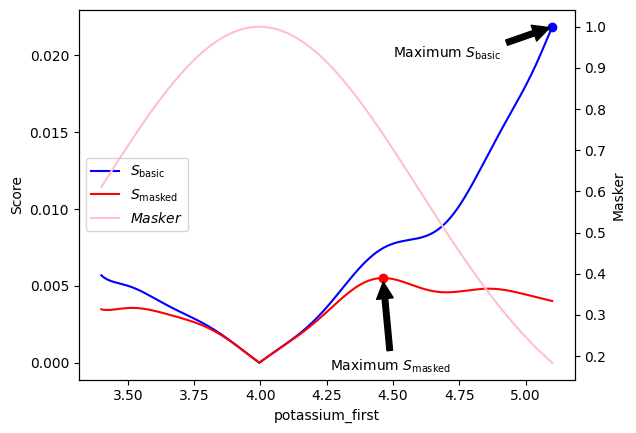

In [6]:
sve= res[-1][res[0][:2]]
sigma = 0.6
X= np.linspace(*sve.variable_bounds,1000)
Y= sve.regressor.predict(X.reshape(-1,1))
init_X = X[350]
init_Y = Y[350]
Y= Y-init_Y
fig, ax = plt.subplots()
secondary_ax = ax.twinx()
secondary_ax.plot(X, (np.exp(-0.5*((X-init_X)/sigma)**2)), color='pink', label='$Masker$')
ax.plot(X, np.abs(Y), color='blue', label='$S_\\text{basic}$')
# plt.plot(X, Y*training_data[sve.explainable_variable].std()/abs(X-init_X))
ax.plot(X, (np.exp(-0.5*((X-init_X)/sigma)**2)*np.abs(Y)), color='red', label='$S_\\text{masked}$')
ax.plot([], [], color='pink', label='$Masker$')
# ax.scatter(init_X, init_Y, color='red')
# ax.set_ylim(0.005, 0.035)

ax.legend(loc=6)
ax.set_ylabel('Score')
secondary_ax.set_ylabel('Masker')
ax.set_xlabel(sve.explainable_variable)

ax.scatter(
    X[np.argmax(Y)],
    np.max(Y),
    color='blue'
)

ax.scatter(
    X[np.argmax((np.exp(-0.5*((X-init_X)/sigma)**2)*Y))],
    np.max((np.exp(-0.5*((X-init_X)/sigma)**2)*Y)),
    color='red'
)

ax.annotate(
    'Maximum $S_\\text{basic}$',
    xy=(X[np.argmax(Y)], np.max(Y)),
    xytext=(X[np.argmax(Y)]-0.6, np.max(Y)-0.002),
    arrowprops=dict(facecolor='black', shrink=0.05),
)

ax.annotate(
    'Maximum $S_\\text{masked}$',
    xy=(X[np.argmax((np.exp(-0.5*((X-init_X)/sigma)**2)*Y))], np.max((np.exp(-0.5*((X-init_X)/sigma)**2)*Y))),
    xytext=(X[np.argmax((np.exp(-0.5*((X-init_X)/sigma)**2)*Y))]-0.2, np.max((np.exp(-0.5*((X-init_X)/sigma)**2)*Y))-0.006),
    arrowprops=dict(facecolor='black', shrink=0.05),
)
plt.savefig('../../figures/scoring.eps',bbox_inches='tight')


In [7]:
list(sve.__dict__.keys())

['underlying_model',
 'target_variable',
 'explainable_variable',
 'regressor_type',
 'explanation_point',
 'variable_bounds',
 'samples',
 'regressor',
 'explanation_dataset']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


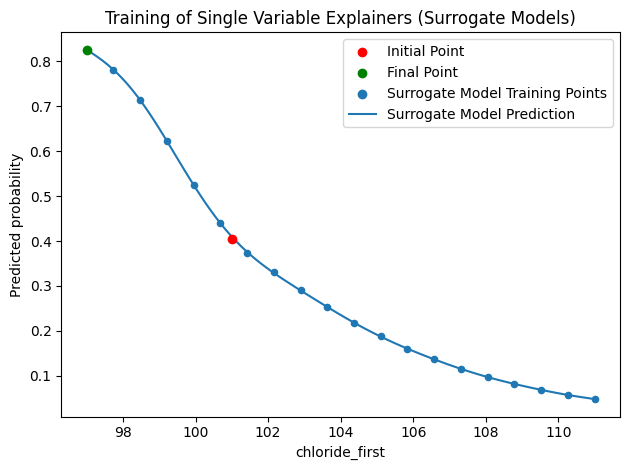

In [23]:
res[1].plot(show_arrow=False)
plt.scatter([], [], color='red', label='Initial Point')
plt.scatter([], [], color='green', label='Final Point')
plt.scatter([], [], color='C0', label='Surrogate Model Training Points')
plt.plot([], [], color='C0', label='Surrogate Model Prediction')
plt.legend()
plt.title('Training of Single Variable Explainers (Surrogate Models)')
plt.tight_layout()
plt.savefig('../../figures/single_variable_explainer_training.eps',bbox_inches='tight')